# Geodesics

It is now time to discuss geodesics computationally. We will do so with the manifold defined by the graph of
\begin{equation*}
    z = \cos(\sqrt{x^2 + y^2}).
\end{equation*}

The first step is to calculate the metric. To that end, start from the Euclidean metric of $\mathbb{R}^3$ in cylindrical coordinates:
\begin{equation*}
    g = \mathrm{d}r\otimes \mathrm{d}r + r^2 \mathrm{d}\theta\otimes \mathrm{d}\theta + \mathrm{d}z\otimes \mathrm{d}z,
\end{equation*}
and replace $\mathrm{d}z$ using $\mathrm{d}z = \mathrm{d}[\cos(r)] = -\sin(r)\mathrm{d}r$:
\begin{equation*}
    g = \left(1 + \sin^2(r)\right)\mathrm{d}r\otimes \mathrm{d}r + r^2 \mathrm{d}\theta\otimes \mathrm{d}\theta.
\end{equation*}

We can obtain the Christoffel symbols for this metric with `einsteinpy`:

In [17]:
import sympy as smp 
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib widget

In [18]:
# set coordinate system as smp.symbols
r, theta = smp.symbols("r theta")

# create metric
g_sym = smp.diag(1 + (3 * smp.sin(r))**2, r**2).tolist()
g = MetricTensor(g_sym, [r, theta])

# Compute Christoffel symbols
CS = ChristoffelSymbols.from_metric(g)
CS.tensor()

[[[9*sin(r)*cos(r)/(9*sin(r)**2 + 1), 0], [0, -r/(9*sin(r)**2 + 1)]], [[0, 1/r], [1/r, 0]]]

We are now ready to build the geodesic equations, which we will then solve numerically using `odeint` from `scipy.integrate`. This requires us to cast the geodesic equations as follows:
\begin{align*}
    \frac{\mathrm{d} x^r}{\mathrm{d} t} &= v^r\\
    \frac{\mathrm{d} v^r}{\mathrm{d} t} &= 
    -\Gamma^r_{\mu\nu} v^\mu v^\nu \equiv F^r \\
    \frac{\mathrm{d} x^\theta}{\mathrm{d} t} &= v^\theta\\
    \frac{\mathrm{d} v^\theta}{\mathrm{d} t} &= -\Gamma^\theta_{\mu\nu} v^\mu v^\nu \equiv F^\theta,
\end{align*}
where, $x^r$ and $x^\theta$ are usually written as $r$ and $\theta$, of course. Let us define the functions $F^\mu$ symbolically:

In [ ]:
# define symbols for the trajectory, its velocity and its parameter 
xs = [r, theta]
vs = smp.symbols("v^r v^theta")
t = smp.symbols("t")

# left-hand side of the geodesic equations for the velocities
Fs = [sum(
            -CS[i, j, k] * vj * vk   
            for j, vj in enumerate(vs) for k, vk in enumerate(vs)
      )
      for i, xi in enumerate(xs)]

After the dust settles, we can see what our left-hand sides are:

In [22]:
Fs[0]

r*v^theta**2/(9*sin(r)**2 + 1) - 9*v^r**2*sin(r)*cos(r)/(9*sin(r)**2 + 1)

In [6]:
Fs[1]

-2*v^r*v^theta/r

In [7]:
# list of numerical functions: [F^r(t, x^r, x^theta, v^r, v^theta), F^theta(t, x^r, x^theta, v^r, v^theta)]
Fs_num = [smp.lambdify((t, *xs, *vs), Fs[0]), smp.lambdify((t, *xs, *vs), Fs[1])]  
# the syntax *list unpacks the list into whatever we choose (in this case, into arguments of the functions)

# set up system of differential equations for odeint 
def dfdt(f, t):
    xr, xtheta, vr, vtheta = f
    return [
        vr, 
        vtheta,
        Fs_num[0](t, xr, xtheta, vr, vtheta),
        Fs_num[1](t, xr, xtheta, vr, vtheta)
    ]

# time array and initial conditions
time = np.linspace(0, 5 * np.pi, 100)
initial_conditions = np.array([np.pi, 0, 0, 1])  # r, theta, vr, vtheta

# solve differential equations
sol = odeint(dfdt, initial_conditions, time)
# rename solutions (only the positions here)
xr, xtheta = sol[:, 0], sol[:, 1]

We can now represent the geodesic trajectory by going back to Cartesian coordinates:
\begin{align*}
    x &= r \cos(\theta)\\
    y &= r \sin(\theta)\\
    z &= 3\cos(r)
\end{align*}

(-3.0, 6.0)

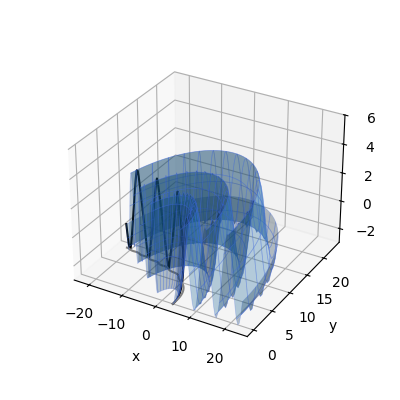

In [11]:
# trajectory in cartesian coordinates
x_t = xr * np.cos(xtheta)
y_t = xr * np.sin(xtheta)
z_t = 3 * np.cos(xr) 

# surface coordinates
r_s = (np.linspace(np.min(xr), np.max(xr), 50)).reshape(-1, 1)
theta_s = (np.linspace(np.min(xtheta), min(np.max(xtheta), 2*np.pi), 50)).reshape(1, -1)

x_s = r_s * np.cos(theta_s)
y_s = r_s * np.sin(theta_s)
z_s = 3 * np.cos(r_s) 

# plots
fig, axs = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(4, 4))

# plot surface
axs.plot_surface(x_s, y_s, z_s, alpha=0.3, edgecolor='royalblue', lw=0.5, rstride=3, cstride=3)

# plot trajectory
axs.plot(x_t, y_t, z_t, c="k")
axs.plot(x_t, y_t, [-3]*len(time), c="gray")
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.set_zlim(-3, 6)

# Geodesics in an expanding universe

Once again, we can take the metric for an isotropically expanding universe
$$
g = - \mathrm{d}(ct)\otimes \mathrm{d}(ct) + a^2(t) \delta_{ij} \left(\mathrm{d}x^i\otimes\mathrm{d}x^j\right),
$$
and focus on $x^2 = x^3 = 0$.

In [104]:
# coordinate system
ct, x = smp.symbols("ct, x")
a = smp.Function("a")(ct)

# metric
g = MetricTensor([[-1, 0], [0, a**2]], [ct, x])
# g.tensor()

In [105]:
# christoffel symbols
CS = ChristoffelSymbols.from_metric(g)
# CS.tensor()

In [106]:
# scale of time to measure the expansion scale factor
cT = smp.symbols("cT")

# concrete scale factor
a_concrete = smp.sqrt(ct / cT)

# geodesic coordinates, velocities and affine parameter
xs = [ct, x]
vs = smp.symbols("v^{ct} v^x")
s = smp.symbols("s")

# right-hand side of the geodesic equations for the velocities (as before)
Fs = [sum(
            -CS[i, j, k] * vj * vk   
            for j, vj in enumerate(vs) for k, vk in enumerate(vs)
      ).subs([(a, a_concrete), (cT, 1)]).doit().simplify()
      for i, xi in enumerate(xs)]
# we replace in the concrete scale factor and expansion scale.
# setting cT = 1 means that we use units in which it takes that value. 
# we force sympy to actually take the derivative with .doit(), and finally simplify fractions


In [107]:
Fs[0]

-v^x**2/2

In [108]:
Fs[1]

-v^x*v^{ct}/ct

This means that the geodesic equations are
\begin{align*}
    \frac{\mathrm{d}^2(ct)}{\mathrm{d}\lambda^2} &= - \frac12 \left(\frac{\mathrm{d}x}{\mathrm{d}\lambda}\right)^2\\
    \frac{\mathrm{d}^2x}{\mathrm{d}\lambda^2} &= - \frac{1}{ct} \frac{\mathrm{d}x}{\mathrm{d}\lambda}\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}
\end{align*}

In [ ]:
# list of numerical functions: [F^ct(s, ct, x, v^ct, v^x), F^theta(s, ct, x, v^ct, v^x)]
Fs_num = [smp.lambdify((s, *xs, *vs), Fs[0]), smp.lambdify((s, *xs, *vs), Fs[1])]

# set up system of equations
def dfdt(f, s):
    ct, x, vct, vx = f
    return [
        vct,
        vx,
        Fs_num[0](s, ct, x, vct, vx),
        Fs_num[1](s, ct, x, vct, vx)
    ]

We are now going to solve the geodesic equations for trajectories starting from the point (event) $p$, with coordinate s$ct = cT$ and $x = 0$, with an affine parameter, which we may take to be the proper time without any loss. To that end, we need to input the initial 4-velocity of the trajectory $v^\mu$, as measured by a comoving observer (one whose $x$ coordinate remains constant). Because the coordinate system we have chosen is such that $g_{\mu\nu} = \eta_{\mu\nu}$, we know that $v^\mu = (\gamma c, \gamma \mathrm{v})$, where $\mathrm{v}$ is the velocity measured by the comoving observer, and $\gamma = \frac1{\sqrt{1 - (\mathrm{v}/c)^2}}$.

The above method manages to produce initial 4-velocities for time-like trajectories, such as those followed by massive test particles. Let us see how they look and deal with the null geodesics of massless particles afterwards.

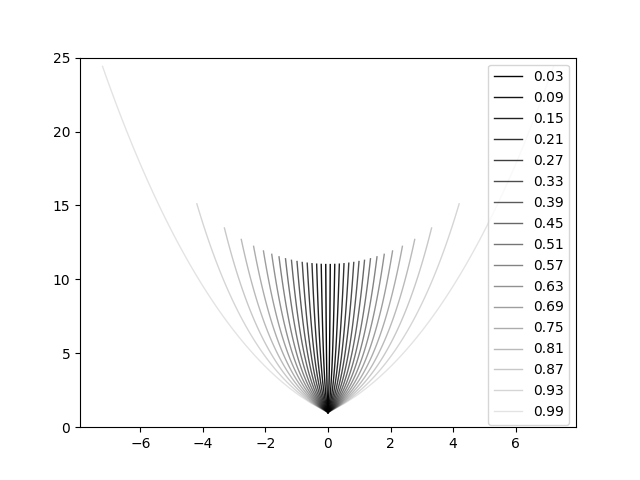

In [110]:
# gamma factor (measures the time dilation between a comoving observer, whose spatial coordinate is x = 0 at all times, and an observer following the geodesic trajectory)
def gamma(v):
    return 1 / np.sqrt(1 - v**2)
    # we measure the velocity in units of c here
    
# set of initial conditions starting from point (ct = 1, x = 0)
vs = np.linspace(-0.99, 0.99, 34)
initial_conditions = [
    np.array([1, 0, gamma(v), v * gamma(v)]) for v in vs
]

# parameter range
s_range = np.linspace(0, 10, 100)

# create lists to hold the multiple trajectories
ct_t, x_t = [], []

# solve ode system
for initial in initial_conditions:
    sol = odeint(dfdt, initial, s_range)
    ct_t.append(sol[:, 0])
    x_t.append(sol[:, 1])

plt.figure()
for x, ct, v in zip(x_t, ct_t, vs):
    if v > 0:
        plt.plot(x, ct, c="k", lw=1, label=np.round(v, 2), alpha=1-0.9*np.abs(v))
    else:
        plt.plot(x, ct, c="k", lw=1, alpha=1-0.9*np.abs(v))

plt.ylim(0, 25)
plt.legend()

When $|\mathrm{v}/c|$ approaches $1$, the above procedure to assign an initial 4-velocity is not valid anymore, because we cannot use the proper time of the trajectory as a parameter: it is equal to zero throughout the whole trajectory!

This does not mean that the geodesic equations that we have derived are not valid. Certainly, there will be geodesic trajectories defined for massless particles (null geodesics), which can be affinely parametrized. It just so happens that the proper time is no longer a valid parameter. Still, we can conceive such an affine parametrization, and thus the geodesic equations still hold. We need, however, another way to assign initial velocities from whatever we do know (or can know) of the massless particles (let's just call them photons, shall we?). A natural way to do so is to demand that our affine parameter $\lambda$ is such that
$$
p^\mu = \frac{\mathrm{d}x^\mu}{\mathrm{d}\lambda},
$$
that is, to relate the 4-velocity to something physical like the particle's 4-momentum. In locally inertial coordinates, we know that $p^\mu = (E/c, \mathrm{p})$, where $E = \mathrm{p}c$, because $g_{\mu\nu}p^\mu p^\nu=-m^2c^2=0$. In such coordinates, the comoving observer will have a 4-velocity still given by $u^\mu = (c, 0)$. Thus, $u_\mu p^\mu = -E$. What this equation means is that the comoving observer measures the photon's energy to be $E$ or, equivalently, with a given frequency $\omega = \frac E\hbar$. 

Intuitively, the situation we are describing can be thought of as follows. The comoving observer turns on a laser that emits light of frequency $\omega$, and propagates away through a null geodesic. The trajectory still follows the geodesic equations. We could perfectly well set some initial conditions using the momentum $\mathrm{p} = \hbar\omega/c$.

There is, however, a simpler way to find $ct$ as a function of $x$, which is to force the 4-momentum to remain light-like or null (null condition):
$$
0 = g_{\mu\nu} p^\mu p^\nu = - \left(\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}\right)^2 + a^2(ct) \left(\frac{\mathrm{d}x}{\mathrm{d}\lambda}\right)^2 \implies \frac{\mathrm{d}(ct)}{\mathrm{d}x} = a(ct)
$$
You may check that, for $a(ct) = ct/cT$, the solution is 
$$
ct = \frac{(x - x(0))^2}{4cT},
$$
namely, the walls of the light-cones are bent according to sections of a parabola. We plot the light-cone together with the light-like trajectories below:

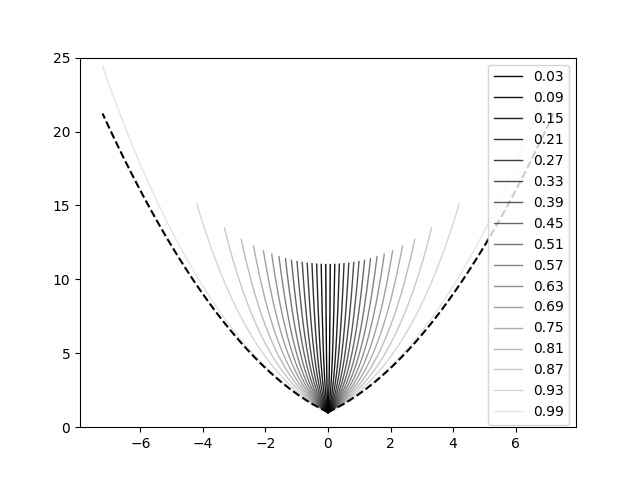

In [116]:
plt.figure()
for x, ct, v in zip(x_t, ct_t, vs):
    if v > 0:
        plt.plot(x, ct, c="k", lw=1, label=np.round(v, 2), alpha=1-0.9*np.abs(v))
    else:
        plt.plot(x, ct, c="k", lw=1, alpha=1-0.9*np.abs(v))

# light lines
plt.plot(x_t[-1], (x_t[-1] + 2)**2 / 4, c="k", ls="--")
plt.plot(x_t[0], (x_t[0] - 2)**2 / 4, c="k", ls="--")

plt.ylim(0, 25)
plt.legend()

What we have done above is well and good. However, there is some genuine interest in obtaining at least $\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}$. Indeed, if we take the null condition above, we can eliminate $\frac{\mathrm{d}x}{\mathrm{d}\lambda}$ from the first geodesic equation and arrive at
$$
\frac{\mathrm{d}^2(ct)}{\mathrm{d}\lambda^2} = -\frac{1}{a(ct)}\frac{\mathrm{d}a(ct)}{\mathrm{d}(ct)} \left(\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}\right)^2,
$$
where we have kept the general scale factor $a$. We can solve for $\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}$ by noticing that
$$
\frac{\mathrm{d} a}{\mathrm{d}\lambda} = \frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}\frac{\mathrm{d}a}{\mathrm{d}(ct)},
$$
which implies
$$
\frac{\mathrm{d}^2(ct)}{\mathrm{d}\lambda^2} = -\frac{1}{a(ct)}\frac{\mathrm{d}a(ct)}{\mathrm{d}\lambda} \left(\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}\right).
$$
If we introduce $\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}\equiv f$, we can write
$$
\frac{\mathrm{d}\ln(f)}{\mathrm{d}\lambda} = - \frac{\mathrm{d}\ln(a)}{\mathrm{d}\lambda}.
$$
It is then trivial to reach
$$
\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda} = \frac{\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}(0)}{a(\lambda)},
$$
but we had already related the initial condition of the 4-velocity to the 4-momentum, such that, $\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}(0) = p^0 = \frac{\hbar\omega}{c}$, where $\omega$ was the photon frequency as it is emitted from the comoving observer's laser:
$$
\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda} = \frac{\hbar\omega}{c a(\lambda)},
$$

Now, consider the following scenario, illustrated in the figure below. A first comoving observer ($x=0$) turns on their laser at the event $p$, which emits photons that travel along a null-geodesic. Eventually, these photons reach another comoving observer $x = 3$, at the intersection between the parabola and the orange world-line. We know that, at that point, the photon energy measured by the second observer will be $p^\mu u_\mu$, where $u_\mu$ is the observer's 4-velocity. With the given metric and coordinates, any comoving observer has a 4-velocity given by $u^\mu = (c, 0)$. As for the photon's 4-momentum, we have smartly chosen the parametrization to be such that $p^\mu = \frac{\mathrm{d}x^\mu}{\mathrm{d}t}$, and we have been able to find a concise expression for $\frac{\mathrm{d}(ct)}{\mathrm{d}\lambda}$. Fitting all the pieces of the puzzle together, we arrive at
$$
g_{\mu\nu}u^\mu p^\nu = g_{00} c \frac{\mathrm{d}(ct)}{\mathrm{d}\lambda} = \frac{\hbar\omega}{a(\lambda)}.
$$
This equation means that the second observer will see the frequency reduced by a factor $1/a$. In other words, in the expanding universe described by our metric, photons are "stretched out" as they travel through spacetime. This happens in our own universe, and is known as cosmological redshift.  


(0.0, 25.0)

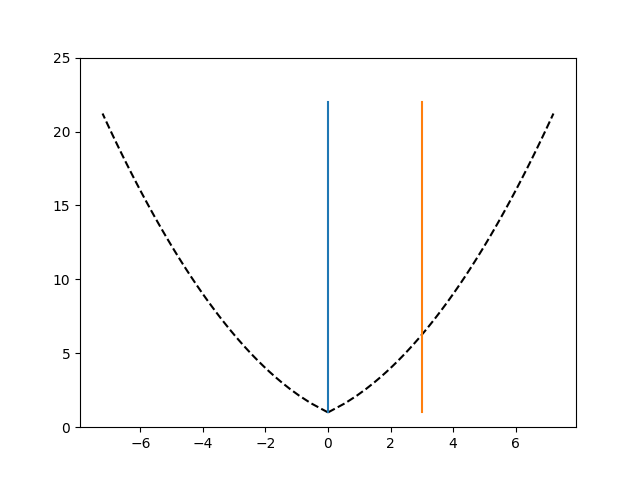

In [121]:
plt.figure()

# light lines
plt.plot(x_t[-1], (x_t[-1] + 2)**2 / 4, c="k", ls="--")
plt.plot(x_t[0], (x_t[0] - 2)**2 / 4, c="k", ls="--")
plt.plot([0, 0], [1, 22])
plt.plot([3, 3], [1, 22])

plt.ylim(0, 25)

Note:
> Another way to derive the equations of motion of massless particles is to start from the following relativistic Lagrangian:
\begin{equation*}
    L = e(\lambda) g_{\mu\nu}\frac{\mathrm{d}x^\mu}{\mathrm{d}\lambda}\frac{\mathrm{d}x^\nu}{\mathrm{d}\lambda}
\end{equation*}
where $e(\lambda)$ is a Lagrange multiplier whose equation of motion is precisely $g_{\mu\nu}\frac{\mathrm{d}x^\mu}{\mathrm{d}\lambda}\frac{\mathrm{d}x^\nu}{\mathrm{d}\lambda} = 0$, thus ensuring that the resulting trajectory is light-like.